In [1]:
! pip install langchain langchain-openai langchain-community langgraph python-dotenv faiss-cpu pypdf



[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
from dotenv import load_dotenv
load_dotenv()

In [ ]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_core.tools import tool
from langgraph.graph import StateGraph, START
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, BaseMessage
from langgraph.prebuilt import ToolNode, tools_condition

In [ ]:
#load_dotenv()

In [9]:
llm = ChatOpenAI(model='gpt-4o')

In [10]:
loader = PyPDFLoader("vishruth_ai.pdf")
docs = loader.load()

In [11]:
len(docs)

2

In [12]:
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = splitter.split_documents(docs)

In [13]:
len(chunks)

5

In [15]:
embeddings = OpenAIEmbeddings(model='text-embedding-ada-002')
vector_store = FAISS.from_documents(chunks, embeddings)

In [16]:
vector_store

In [17]:
retriever = vector_store.as_retriever(search_type='similarity', search_kwargs={'k':4})

In [18]:
@tool
def rag_tool(query):

    """
    Retrieve relevant information from the pdf document.
    Use this tool when the user asks factual / conceptual questions
    that might be answered from the stored documents.
    """
    result = retriever.invoke(query)

    context = [doc.page_content for doc in result]
    metadata = [doc.metadata for doc in result]

    return {
        'query': query,
        'context': context,
        'metadata': metadata
    }

In [19]:
tools = [rag_tool]
llm_with_tools = llm.bind_tools(tools)

In [20]:
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [21]:
def chat_node(state: ChatState):

    messages = state['messages']

    response = llm_with_tools.invoke(messages)

    return {'messages': [response]}

In [22]:
tool_node = ToolNode(tools)

In [23]:
graph = StateGraph(ChatState)

graph.add_node('chat_node', chat_node)
graph.add_node('tools', tool_node)

graph.add_edge(START, 'chat_node')
graph.add_conditional_edges('chat_node', tools_condition)
graph.add_edge('tools', 'chat_node')

chatbot = graph.compile()

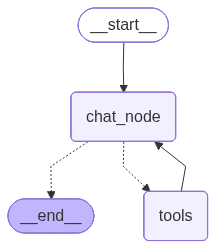

In [24]:
chatbot

In [25]:
result = chatbot.invoke(
    {
        "messages": [
            HumanMessage(
                content=(
                    "can you tell me about the canidate is he suitable for an gen ai internship"
                )
            )
        ]
    }
)

In [26]:
print(result['messages'][-1].content)

The candidate, Vishruth HV, appears to be highly suitable for a Gen AI internship based on the following qualifications and experiences:

1. **Educational Background**: 
   - Final-year B.Tech student in Computer Science and Engineering with a specialization in AI and Machine Learning from PES University.
   - Relevant coursework includes Data Structures and Algorithms, Linear Algebra, Probability and Statistics, Machine Learning, and Deep Learning.

2. **Technical Skills**:
   - Proficient in programming languages such as Python, C, C++, and Shell scripting.
   - Experienced with ML and data science tools like PyTorch, TensorFlow, Scikit-learn, Pandas, and NumPy.
   - Strong grasp of mathematical tools such as Linear Algebra, Probability, Optimization, and Statistical Inference.
   
3. **Practical Experience**: 
   - Has worked as an ML Research Intern at RAPID Lab, where they contributed to a deep learning pipeline for diabetic retinopathy classification.
   - Involved in model evalu